In [1]:
from pyomo.environ import *
import pandas as pd
import matplotlib.pyplot as plt
import latexify

# 1ª Parte: Passo-a-passo da criação de um modelo de otimização

## 1. Importando os dados

Como vimos, a política de Entrada Mínima é desenhada nas dimensões de Grupo de Risco, Parcela e Entrada. Portanto, vamos definir um conjunto para cada uma delas, discretizando nossos dados em faixas.

Para este case, os dados aqui apresentados são fictícios, gerados randomicamente apenas para exemplo deste exercício. Na prática, porém, pode-se trazer os dados de propostas e de inadimplência dos últimos 6 meses, agregados nas faixas que desejamos construir a política (Grupo de Risco, Entrada, Parcela).

In [2]:
dados = pd.read_csv("dados.csv", delimiter = ";", decimal = ",")
dados

,GR,Entrada,Parcela,Valor_Proposta,Inadimplencia
0,A,50,12,42071,0.001767
1,A,50,24,39829,0.005357
2,A,50,36,24569,0.019939
3,A,50,48,36311,0.022628
4,A,50,60,43397,0.041957
...,...,...,...,...,...
120,E,10,12,22814,0.174626
121,E,10,24,33351,0.125463
122,E,10,36,36179,0.304202
123,E,10,48,49671,0.126034


### 1.1. Definindo os conjuntos de dados

Grupo de Risco:

In [3]:
dados["GR"].unique()

array(['A', 'B', 'C', 'D', 'E'], dtype=object)

In [4]:
dados["Valor_Inad"] = dados.Valor_Proposta*dados.Inadimplencia
dados_grouped_GR = dados.groupby("GR").agg({"Valor_Proposta":sum, "Valor_Inad":sum})
dados_grouped_GR["Inadimplencia_Pond"] = dados_grouped_GR.Valor_Inad/dados_grouped_GR.Valor_Proposta
dados_grouped_GR

,Valor_Proposta,Valor_Inad,Inadimplencia_Pond
GR,,,
A,851532,35041.836078,0.041152
B,680611,49915.918755,0.073340
C,778751,96957.167189,0.124503
D,797616,126537.504326,0.158645
E,739666,121716.360871,0.164556


Parcelas:

In [5]:
dados["Parcela"].unique()

array([12, 24, 36, 48, 60], dtype=int64)

In [6]:
dados_grouped_Parcela = dados.groupby("Parcela").agg({"Valor_Proposta":sum, "Valor_Inad":sum})
dados_grouped_Parcela["Inadimplencia_Pond"] = dados_grouped_Parcela.Valor_Inad/dados_grouped_Parcela.Valor_Proposta
dados_grouped_Parcela

,Valor_Proposta,Valor_Inad,Inadimplencia_Pond
Parcela,,,
12,732942,28787.294230,0.039276
24,737308,62634.650139,0.084950
36,752792,102980.414097,0.136798
48,881559,120774.079296,0.137001
60,743575,114992.349457,0.154648


Entrada:

In [7]:
dados["Entrada"].unique()

array([50, 40, 30, 20, 10], dtype=int64)

In [8]:
dados_grouped_Entrada = dados.groupby("Entrada").agg({"Valor_Proposta":sum, "Valor_Inad":sum})
dados_grouped_Entrada["Inadimplencia_Pond"] = dados_grouped_Entrada.Valor_Inad/dados_grouped_Entrada.Valor_Proposta
dados_grouped_Entrada

,Valor_Proposta,Valor_Inad,Inadimplencia_Pond
Entrada,,,
10,744431,142377.493361,0.191257
20,752923,118030.024557,0.156762
30,755047,81528.757642,0.107978
40,849105,60414.982530,0.071151
50,746670,27817.529129,0.037255


É importante manter a ordem dos conjuntos do menor risco para o maior risco, de forma que, conforme o índice do array cresce, o risco cresce também.

Vamos utilizar índices, e não os valores originais das faixas dos conjuntos, no nosso modelo de otimização. Em breve vou mostrar o porquê.

In [9]:
GrupoRisco = dados["GR"].unique() # array(['A', 'B', 'C', 'D', 'E'], dtype=object)
Parcelas = dados["Parcela"].unique() # array([12, 24, 36, 48, 60], dtype=int64)
Entrada = dados["Entrada"].unique() # array([50, 40, 30, 20, 10], dtype=int64)

#listas com os índices de cada conjunto
listGrupoRisco = [i+1 for i in range(len(GrupoRisco))] 
listParcelas = [i+1 for i in range(len(Parcelas))]
listEntrada = [i+1 for i in range(len(Entrada))]

#dicionários com o de-para de índice para faixa de cada conjunto
deParaGrupoRisco = {GrupoRisco[i]:i+1 for i in range(len(GrupoRisco))}
deParaParcelas = {Parcelas[i]:i+1 for i in range(len(Parcelas))}
deParaEntrada = {Entrada[i]:i+1 for i in range(len(Entrada))}

#dicionário do domínio da combinação de Grupos de Risco, Parcelas e Entradas
dictGxPxE = {
    (g, p, e)
    for g in listGrupoRisco
    for p in listParcelas
    for e in listEntrada
}

### 1.2. Montando os dicionários dos parâmetros Valor Proposta e Inadimplência

Para cada combinação de Grupo de Risco, Parcela e Entrada, eu gero um dicionário para os parâmetros de Valor Proposta e Inadimplência. Estes serão usados na construção das nossas restrições e função objetivo.

In [10]:
paramValor = {}
paramInadimplencia = {}
for g in GrupoRisco:
    for e in Entrada:
        for p in Parcelas:
            paramValor[(deParaGrupoRisco[g],deParaParcelas[p],deParaEntrada[e])] = dados.loc[(dados.GR==g)&(dados.Entrada==e)&(dados.Parcela==p)].Valor_Proposta.iloc[0]
            paramInadimplencia[(deParaGrupoRisco[g],deParaParcelas[p],deParaEntrada[e])] = dados.loc[(dados.GR==g)&(dados.Entrada==e)&(dados.Parcela==p)].Inadimplencia.iloc[0]

### 1.3. Definindo o limite de risco (limite máximo de inadimplência do público aprovado)

In [11]:
LimiteRisco = 0.03

## 2. Criando o modelo de otimização (MILP: Mixed-Integer Linear Programming)

### 2.1. Instância do modelo, conjuntos e variável de decisão

In [12]:
model = ConcreteModel(name="credit")

model.setGrupoRisco = Set(initialize=listGrupoRisco)
model.setParcelas = Set(initialize=listParcelas)
model.setEntrada = Set(initialize=listEntrada)

#### Variável de decisão: Política de Crédito

Precisamos de uma variável de decisão que represente a tomada de decisão de abrir ou fechar a política para cada combinação de Grupo de Risco, Parcela e Entrada. Dessa forma, criamos 5 x 5 x 5 = 125 variáveis de decisão binárias, que assumem 1 caso a política esteja aberta ou 0 caso ela esteja fechada.

In [13]:
model.politica = Var(model.setGrupoRisco, model.setParcelas, model.setEntrada, within=Binary, name="politica")

#### Variável auxiliar: Valor Aprovado

Utilizamos uma variável auxiliar para simplificar a escrita e a obtenção dos resultados no final do modelo. Esta não é obrigatória, mas por questões pedagógicas, estou criando-a para termos um exemplo de variável contínua em Pyomo, além da binária da política que acabamos de definir. 

OBS: como o valor dela é sempre positivo, definimos esta no domínio dos reais não-negativos, e associamos a esta um valor máximo (upper bound) igual à soma de todo o valor aprovado das propostas (poderíamos associar aqui, também, o valor de proposta de cada casela para deixar o modelo mais "apertado").

In [14]:
def vaBounds(model, g, p, e):
    #retorna o lower bound e o upper bound para cada combinação de g, p, e
    return (0, paramValor[(g, p, e)])

In [15]:
model.valorAprovado = Var(model.setGrupoRisco, model.setParcelas, model.setEntrada, within=NonNegativeReals, bounds=vaBounds, name="valor_aprovado")

### 2.2. Restrição de definição da variável Valor Aprovado

In [16]:
model.defValorAprovado = ConstraintList()

for (g, p, e) in dictGxPxE:
    model.defValorAprovado.add(
        model.valorAprovado[(g, p, e)] == model.politica[(g, p, e)] * paramValor[(g, p, e)]
    )

### 2.3. Restrição de limite de risco (limite máximo de risco do valor aprovado)

In [17]:
def limiteRisco(model):
    return quicksum((LimiteRisco - paramInadimplencia[(g,p,e)]) * model.valorAprovado[(g, p, e)]
             for (g, p, e) in dictGxPxE) >= 0

model.limiteRisco = Constraint(rule = limiteRisco)

### 2.4. Restrições de riscos operacionais

Lembra da ordenação das faixas e uso dos índices nos conjuntos das variáveis? Aqui incluímos as restrições de risco operacional, no qual a política de maior risco precisa ser igual ou mais fechada do que a de menor risco.

In [18]:
model.politicaFechadaGrupoRisco = ConstraintList()

for (g, p, e) in dictGxPxE:
            if g > 1:
                model.politicaFechadaGrupoRisco.add(
                    model.politica[(g,p,e)] - model.politica[(g-1,p,e)] <= 0
                )

                
model.politicaFechadaParcelas = ConstraintList()

for (g, p, e) in dictGxPxE:
            if p > 1:
                model.politicaFechadaParcelas.add(
                    model.politica[(g,p,e)] - model.politica[(g,p-1,e)] <= 0
                )
              
            
model.politicaFechadaEntrada = ConstraintList()

for (g, p, e) in dictGxPxE:
            if e > 1:
                model.politicaFechadaEntrada.add(
                    model.politica[(g,p,e)] - model.politica[(g,p,e-1)] <= 0
                )

### 2.4. Função objetivo (maximizar o valor aprovado pela política)

In [19]:
model.Obj = Objective(
    expr=sum(model.valorAprovado[(g, p, e)]
             for (g, p, e) in dictGxPxE),
    sense=maximize
)

## 3. Escolhendo o solver e resolvendo o modelo

In [20]:
model.pprint()

9 Set Declarations
    defValorAprovado_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :  125 : {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125}
    politicaFechadaEntrada_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :  100 : {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40,

In [21]:
#model.write('credit.lp')

solver = SolverFactory('glpk')

results = solver.solve(model)
print(results)


Problem: 
- Name: unknown
  Lower bound: 1438109.0
  Upper bound: 1438109.0
  Number of objectives: 1
  Number of constraints: 426
  Number of variables: 250
  Number of nonzeros: 975
  Sense: maximize
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 71
      Number of created subproblems: 71
  Error rc: 0
  Time: 0.05697941780090332
Solution: 
- number of solutions: 0
  number of solutions displayed: 0



In [33]:
model.pprint()

9 Set Declarations
    defValorAprovado_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :  125 : {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125}
    politicaFechadaEntrada_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :  100 : {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40,

### 3.1. Extraindo a solução das variáveis de decisão

In [22]:
print("\nTOTAL APROVADO: ", model.Obj())
aprov_pot_total = 0
inad_pot_total = 0
aprov_final = 0
inad_final = 0
print("------- Política de Entrada Mínima -------")
for g in listGrupoRisco:
    print("Para o Grupo de Risco: ", GrupoRisco[g-1])
    for p in listParcelas:
        minEntrada = 100
        for e in listEntrada:
            aprov_pot_total += paramValor[(g, p, e)]
            inad_pot_total += paramValor[(g, p, e)] * paramInadimplencia[(g, p, e)]
            if value(model.politica[(g, p, e)].value) > 0.99:
                aprov_final += model.valorAprovado[(g, p, e)].value
                inad_final += model.valorAprovado[(g, p, e)].value * paramInadimplencia[(g, p, e)]
                minEntrada = Entrada[e-1]

        if minEntrada < 100: print("[", GrupoRisco[g-1],"][", Parcelas[p-1], "]: Entrada Mínima: ",minEntrada)
        else: print("[", GrupoRisco[g-1],"][", Parcelas[p-1], "]: Não Opera")


TOTAL APROVADO:  1438109.0
------- Política de Entrada Mínima -------
Para o Grupo de Risco:  A
[ A ][ 12 ]: Entrada Mínima:  10
[ A ][ 24 ]: Entrada Mínima:  10
[ A ][ 36 ]: Entrada Mínima:  20
[ A ][ 48 ]: Entrada Mínima:  20
[ A ][ 60 ]: Entrada Mínima:  20
Para o Grupo de Risco:  B
[ B ][ 12 ]: Entrada Mínima:  10
[ B ][ 24 ]: Entrada Mínima:  40
[ B ][ 36 ]: Entrada Mínima:  50
[ B ][ 48 ]: Entrada Mínima:  50
[ B ][ 60 ]: Entrada Mínima:  50
Para o Grupo de Risco:  C
[ C ][ 12 ]: Entrada Mínima:  20
[ C ][ 24 ]: Entrada Mínima:  40
[ C ][ 36 ]: Não Opera
[ C ][ 48 ]: Não Opera
[ C ][ 60 ]: Não Opera
Para o Grupo de Risco:  D
[ D ][ 12 ]: Entrada Mínima:  30
[ D ][ 24 ]: Entrada Mínima:  50
[ D ][ 36 ]: Não Opera
[ D ][ 48 ]: Não Opera
[ D ][ 60 ]: Não Opera
Para o Grupo de Risco:  E
[ E ][ 12 ]: Entrada Mínima:  30
[ E ][ 24 ]: Entrada Mínima:  50
[ E ][ 36 ]: Não Opera
[ E ][ 48 ]: Não Opera
[ E ][ 60 ]: Não Opera


### 3.2. Cálculo dos principais KPIs do cenário

In [23]:
print("Valor das Propostas do Público Total: ", aprov_pot_total)
print("% inad. Público Total: ", round(inad_pot_total / aprov_pot_total*100, 2),"%")
print("Valor Aprovado Final: ", aprov_final)
print("% inad. Público Final: ", round(inad_final / aprov_final*100,2),"%")
print("% Valor Aprovado: ", round(aprov_final / aprov_pot_total*100,2),"%")

Valor das Propostas do Público Total:  3848176
% inad. Público Total:  11.18 %
Valor Aprovado Final:  1438109.0
% inad. Público Final:  3.0 %
% Valor Aprovado:  37.37 %


# 2ª Parte: Análise de diferentes cenários e Curva de Pareto

## 1. Função com as etapas acima encapsuladas

In [24]:
def modeloOtimizacaoPoliticaCredito(LimiteRisco):

    model = ConcreteModel(name="credit")
    model.setGrupoRisco = Set(initialize=listGrupoRisco)
    model.setEntrada = Set(initialize=listEntrada)
    model.setParcelas = Set(initialize=listParcelas)

    model.politica = Var(model.setGrupoRisco, model.setEntrada, model.setParcelas, within=Binary, name="politica")
    model.valorAprovado = Var(model.setGrupoRisco, model.setParcelas, model.setEntrada, within=NonNegativeReals, bounds=(0, dados.Valor_Proposta.sum()), name="valor_aprovado")
    
    model.defValorAprovado = ConstraintList()

    for (g, p, e) in dictGxPxE:
        model.defValorAprovado.add(
            model.valorAprovado[(g, p, e)] == model.politica[(g, p, e)] * paramValor[(g, p, e)]
        )
        
    def limiteRisco(model):
        return quicksum((LimiteRisco - paramInadimplencia[(g,p,e)]) * model.valorAprovado[(g, p, e)]
                 for (g, p, e) in dictGxPxE) >= 0

    model.limiteRisco = Constraint(rule = limiteRisco)

    
    model.politicaFechadaGrupoRisco = ConstraintList()

    for (g, p, e) in dictGxPxE:
                if g > 1:
                    model.politicaFechadaGrupoRisco.add(
                        model.politica[(g,p,e)] - model.politica[(g-1,p,e)] <= 0
                    )


    model.politicaFechadaParcelas = ConstraintList()

    for (g, p, e) in dictGxPxE:
                if p > 1:
                    model.politicaFechadaParcelas.add(
                        model.politica[(g,p,e)] - model.politica[(g,p-1,e)] <= 0
                    )


    model.politicaFechadaEntrada = ConstraintList()

    for (g, p, e) in dictGxPxE:
                if e > 1:
                    model.politicaFechadaEntrada.add(
                        model.politica[(g,p,e)] - model.politica[(g,p,e-1)] <= 0
                    )  
     
    model.Obj = Objective(
        expr=sum(model.valorAprovado[(g, p, e)]
                 for (g, p, e) in dictGxPxE), sense=maximize
    )
        
    solver = SolverFactory('glpk')

    results = solver.solve(model)
    
    totalAprovado = model.Obj()
    
    aprov_pot_total = 0
    inad_pot_total = 0
    aprov_final = 0
    inad_final = 0
    
    for g in listGrupoRisco:

        for p in listParcelas:

            minEntrada = 100
            for e in listEntrada:
                aprov_pot_total += paramValor[(g, p, e)]
                inad_pot_total += paramValor[(g, p, e)] * paramInadimplencia[(g, p, e)]
                if value(model.politica[(g, p, e)].value) > 0.99:
                    aprov_final += model.valorAprovado[(g, p, e)].value
                    inad_final += model.valorAprovado[(g, p, e)].value * paramInadimplencia[(g, p, e)]
                    minEntrada = Entrada[e-1]
   
    
    return aprov_final, inad_final / aprov_final, aprov_final / aprov_pot_total


## 2. Criando lista com os valores de limites de inadimplência a serem analisados

In [25]:
limitesRisco = [round(i*0.01 + 0.01, 2) for i in range(12)]
limitesRisco

[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12]

## 3. Executando os cenários

In [26]:
taxaAprovacao = {}
valorAprovado = {}
inadAprovado = {}

for limiteRisco in limitesRisco:
    valorAprovado[limiteRisco], inadAprovado[limiteRisco], taxaAprovacao[limiteRisco] = modeloOtimizacaoPoliticaCredito(limiteRisco)

## 4. Análise das Curvas de Pareto para valor aprovado e taxa de aprovação

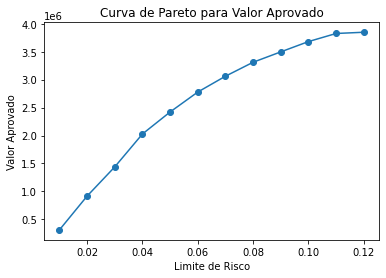

In [27]:
x = valorAprovado.keys()
y = valorAprovado.values()

plt.plot(x, y, 'o-', label='Data')
plt.xlabel('Limite de Risco')
plt.ylabel('Valor Aprovado')
plt.title('Curva de Pareto para Valor Aprovado')

plt.show()

In [28]:
valorAprovado

{0.01: 310161.0,
 0.02: 915166.0,
 0.03: 1438109.0,
 0.04: 2026896.0,
 0.05: 2420855.0,
 0.06: 2777757.0,
 0.07: 3061122.0,
 0.08: 3311097.0,
 0.09: 3496876.0,
 0.1: 3681122.0,
 0.11: 3826054.0,
 0.12: 3848176.0}

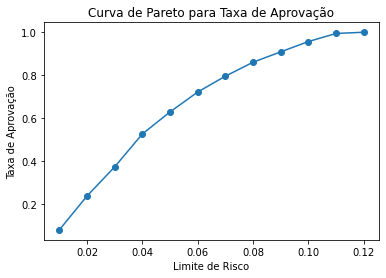

In [29]:
x = taxaAprovacao.keys()
y = taxaAprovacao.values()

plt.plot(x, y, 'o-', label='Data')
plt.xlabel('Limite de Risco')
plt.ylabel('Taxa de Aprovação')
plt.title('Curva de Pareto para Taxa de Aprovação')

plt.show()

In [30]:
taxaAprovacao

{0.01: 0.08059948401528412,
 0.02: 0.23781812474273525,
 0.03: 0.3737118572539302,
 0.04: 0.5267160337780808,
 0.05: 0.6290915488272886,
 0.06: 0.7218373068175676,
 0.07: 0.7954734918569213,
 0.08: 0.8604328388306564,
 0.09: 0.9087099966321707,
 0.1: 0.9565887838809868,
 0.11: 0.9942513024352316,
 0.12: 1.0}

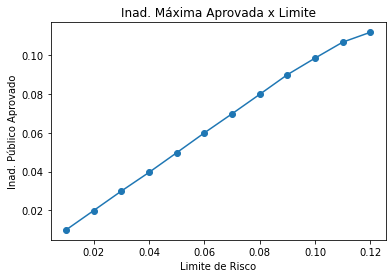

In [31]:
x = inadAprovado.keys()
y = inadAprovado.values()

plt.plot(x, y, 'o-', label='Data')
plt.xlabel('Limite de Risco')
plt.ylabel('Inad. Público Aprovado')
plt.title('Inad. Máxima Aprovada x Limite')

plt.show()

In [32]:
inadAprovado

{0.01: 0.00994342688061368,
 0.02: 0.019938775254354862,
 0.03: 0.029967973502005443,
 0.04: 0.039594854194452855,
 0.05: 0.049728241526803885,
 0.06: 0.05994770889588339,
 0.07: 0.06977936394263934,
 0.08: 0.0798011113639766,
 0.09: 0.08993242731138834,
 0.1: 0.09845832515690031,
 0.11: 0.10669223520631715,
 0.12: 0.11178511253616154}